In [1]:
from src.configuration import conf
import tables
import matplotlib.pyplot as plt
import os
import numpy as np

# Basic Data Extraction
Each variable is a time series accross a single game run.

Unintuitve Variables Encodings:
* player_x_target_states:
  * Before comma: Index of current target ant
  * After comma: conquest progress
  * Negative value if there is no current target

* player_x_score_states:
  * Encodes the score popup animation
  * Before comma: Score to show
  * After comma: animation progress
  * Nan if there the popup animation is not shown
   

In [2]:
# Print game course data sets
output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name
records_folder = os.listdir(output_dir_path + '/')
records = []

for name in records_folder:
    path = output_dir_path + '/' + name
    if os.path.isdir(path):
        for file in os.listdir(path):
            #print(name + '/' + file)
            records.append(name + '/' + file)
    else:
        records.append(name)
#records

In [3]:
def file_to_data_dict(file):
    data = file.root.data
        
    general_data = data[:, 0]
    player_data  = data[:,1:3]
    score_data   = data[:, 3]
    ant_data     = data[:,4:]
    
    identifier = str(int(general_data[0, 3])).zfill(3)
    lap = -1
    p0_idx = -1
    p1_idx = -1
    if len(identifier) == 3:
        lap = int(identifier[0])
        p0_idx = int(identifier[1])
        p1_idx = int(identifier[2])
    
    return {
        
        'player_0_scale_factors' : general_data[:, 0],
        'player_1_scale_factors' : general_data[:, 1],
        'timestamps'             : general_data[:, 2],
        
        'player_0_positions' : player_data[:, 0,: 2],
        'player_1_positions' : player_data[:, 1,: 2],

        'player_0_target_states' : player_data[:, 0, 2],
        'player_1_target_states' : player_data[:, 1, 2],
        
        'player_0_pings' : player_data[:, 0, 3],
        'player_1_pings' : player_data[:, 1, 3],

        'player_0_scores' : score_data[:, 0],
        'player_1_scores' : score_data[:, 1],
        
        'player_0_score_state' : score_data[:, 2],
        'player_1_score_state' : score_data[:, 3],

        'ant_x_positions' : ant_data[:,:, 0],
        'ant_y_positions' : ant_data[:,:, 1],
        'ant_kinds'       : ant_data[:,:, 2],
        
        'lap'    : lap,
        'p0_idx' : p0_idx,
        'p1_idx' : p1_idx,
    }

def path_to_data_dict(path):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name
    file = tables.open_file(output_dir_path + path, mode='r')
    return file_to_data_dict(file)
   

#path = output_dir_path + '/' + records[-8]
comp_only_path = output_dir_path + '/gs_07-10-21_13-52-36/001.h5'
coop_only_path = output_dir_path + '/gs_07-10-21_13-55-05/001.h5'
path = coop_only_path
file = tables.open_file(path, mode='r')
game_data = file_to_data_dict(file)
print(path)

/home/brain/uni/pract/dyadic_task/game_records/gs_07-10-21_13-55-05/001.h5


In [4]:
game_coop = file_to_data_dict(tables.open_file(coop_only_path, mode='r'))
game_comp = file_to_data_dict(tables.open_file(comp_only_path, mode='r'))
comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(game_comp)
print(game_coop['player_0_scores'][-1])
print(game_coop['player_1_scores'][-1])
print(game_comp['player_0_scores'][-1]-len(comp_p0))
print(game_comp['player_1_scores'][-1]-len(comp_p1))
print(game_comp['player_0_scores'][-1])
print(game_comp['player_1_scores'][-1])

NameError: name 'get_scorings' is not defined

In [16]:
def get_game_data_dicts_for_folder(folder_name):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder_name
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    return [file_to_data_dict(file) for file in table_files]

retreat_record = get_game_data_dicts_for_folder('gs_02-09-21_18-56-37')
wg_record = get_game_data_dicts_for_folder('gs_04-09-21_16-26-11')


In [17]:
def check_reliability_in_time(timestamps):
    recording_duration = timestamps[-1] - timestamps[0]
    diff = np.zeros(len(timestamps)-1)
    for i in range(len(timestamps)-1):
        diff[i] = timestamps[i+1] - timestamps[i]
    print(f'Actual Value: {recording_duration}')
    print(f'Target Value: {conf.lap_time}')
    print(f'Difference in time mean actual Value: {diff.mean()}')
    print(f'Difference in time mean target Value: {1 / conf.pos_updates_ps}')
    print(f'Difference in time standard derivation: {diff.std()}')
    
    #Actual - Target Value history
    #.89
    #.77 preproduce game_states
    #.45 use exponential moving average improve time scheduling
    #.38 the same as above but no ping requests and no player movement
    #-.02 rewrote server and introduced new game scheduler with own thread,
    # no moving averages or preprocessing requiered!

check_reliability_in_time(game_data['timestamps'])

Actual Value: 119.97826051712036
Target Value: 300
Difference in time mean actual Value: 0.016665962010990465
Difference in time mean target Value: 0.016666666666666666
Difference in time standard derivation: 0.00046489279642275403


In [18]:
def print_client_field_sizes(game_data):
    print('Initial client field sizes:')
    sf = [game_data['player_0_scale_factors'][0], game_data['player_1_scale_factors'][0]]
    field_server_width, field_server_height = conf.field_size
    print(f'player 1: {int(field_server_width * sf[0])} {int(field_server_height * sf[0])}')
    print(f'player 2: {int(field_server_width * sf[1])} {int(field_server_height * sf[1])}')
    
print_client_field_sizes(game_data)

Initial client field sizes:
player 1: 1774 1053
player 2: 1712 1015


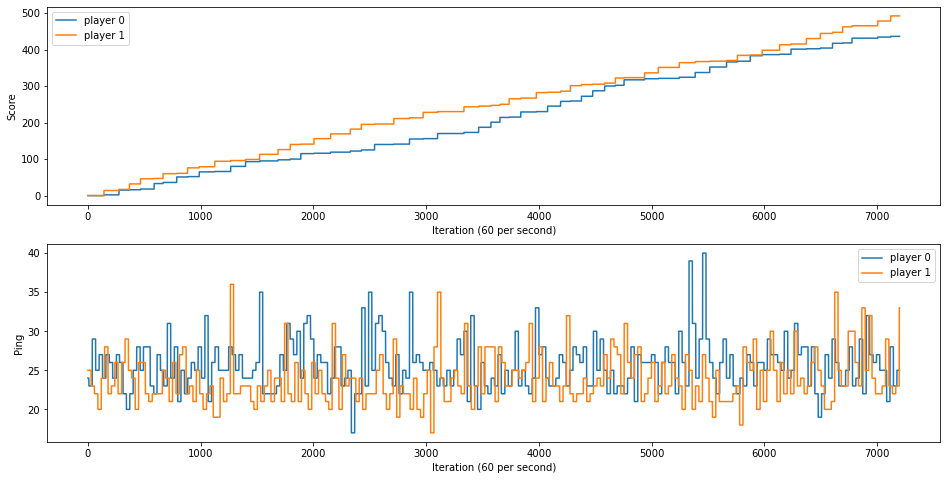

In [19]:
def plot_ping_and_score(game_data):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=((16,8)))
    ax1.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax1.set_ylabel('Score')
    ax1.plot(game_data['player_0_scores'], label='player 0')
    ax1.plot(game_data['player_1_scores'], label='player 1')
    ax1.legend()
    ax2.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax2.set_ylabel('Ping')
    ax2.plot(game_data['player_0_pings'], label='player 0')
    ax2.plot(game_data['player_1_pings'], label='player 1')
    ax2.legend()
    
plot_ping_and_score(game_data)

In [20]:
def vec_ncc(arg_a, arg_b, shift=0):  # a and b should have same length
    a, b = None, None
    if shift >= 0:
        a = arg_a[:len(arg_a)-shift]
        b = arg_b[shift:len(arg_a)]
    else:
        a = arg_a[-1*shift:len(arg_a)]
        b = arg_b[:len(arg_a)+shift]
    a_mean, b_mean = a.mean(0), b.mean(0)
    try:
        normalization_factor = 1/len(a)/(a.std(0).dot(b.std(0)))
        return sum([(a[i]-a_mean).dot(b[i]-b_mean) for i in range(len(a))]) * normalization_factor
    except FloatingPointError as e:
        print(e)
        return 1.
    
def vec_ncc_for_shifts(a, b, shift_dist=10):
    return [vec_ncc(a,b,s) for s in range(-shift_dist,shift_dist+1)]

def best_ncc_shift(a, b, search_dist):
    shifts=list(range(-search_dist,search_dist+1))
    pointer_correlation = vec_ncc_for_shifts(a, b, shift_dist=search_dist)
    max_cor_shift = np.argmax(pointer_correlation) - search_dist
    return max_cor_shift, shifts, pointer_correlation

In [21]:
def frames_to_seconds(frames):
    return [f/conf.pos_updates_ps if f is not None else None for f in frames]

def frames_to_mins(frames):
    return [f/conf.pos_updates_ps/60 if f is not None else None for f in frames]

def plot_cross_correlation(game_data, label):
    p0_pos = game_data['player_0_positions']
    p1_pos = game_data['player_1_positions']
    max_cor_shift, shifts, pointer_correlation_follows = best_ncc_shift(p0_pos, p1_pos, 3 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label=label)
    #print(max_cor_shift)

def plot_cross_correltaion_for_folder(folder, title=''):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    for i in range(len(file_names)):
        plot_cross_correlation(file_to_data_dict(table_files[i]), file_names[i])
    ax = plt.gca()
    ax.set_xlabel('Shifts in Seconds', fontsize=16)
    ax.set_ylabel('Normalized Cross Correlation', fontsize=16)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.title(title)
    plt.axvline(0, c='k')
    plt.axhline(0, c='k')
    #ax.set_xlabel('Minute of recording', fontsize=16)
    plt.xticks(fontsize = 18) 
    plt.yticks(fontsize = 18) 
    #ax.tick_params(
    #    axis='both',          # changes apply to the x-axis
    #    which='both',      # both major and minor ticks are affected
    #    bottom=False,      # ticks along the bottom edge are off
    #    top=False,         # ticks along the top edge are off
    #    labelbottom=False) # labels along the bottom edge are off 
    #for ax in axis:
    #    ax.tick_params(axis='both', which='major', labelsize=18) 
    plt.show()

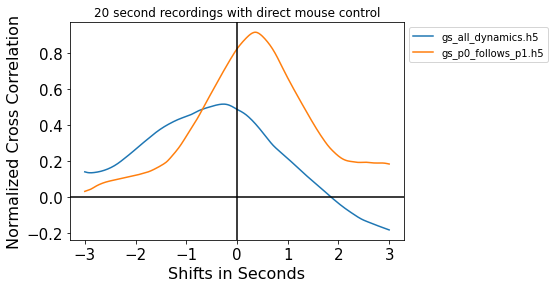

In [25]:
plot_cross_correltaion_for_folder(folder='records_0',
                                  title='20 second recordings with direct mouse control')

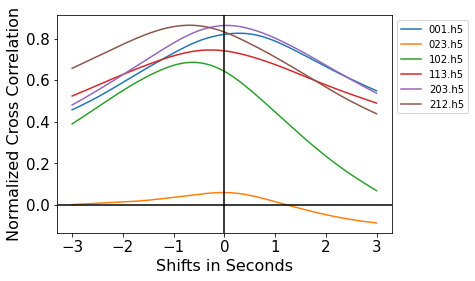

In [26]:
plot_cross_correltaion_for_folder(folder='gs_02-09-21_18-56-37',
                                  title='')

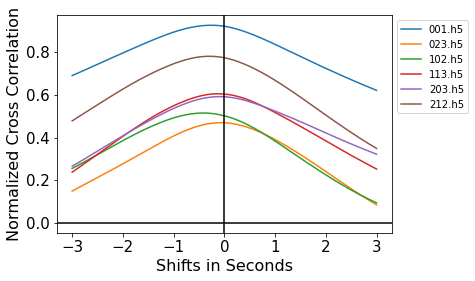

In [27]:
plot_cross_correltaion_for_folder(folder='gs_04-09-21_16-26-11',
                                  title='')

In [22]:
def vec_auto_correlation_for_shifts(a, shifts):
    return [vec_ncc(a,a,s) for s in shifts]

def best_auto_correlation_shift(a, search_dist):
    shifts=list(range(search_dist+1))
    pointer_correlation = vec_auto_correlation_for_shifts(a, shifts)
    max_cor_shift = np.argmax(pointer_correlation) - search_dist
    return max_cor_shift, shifts, pointer_correlation

def plot_auto_correlation(game_data, label):
    p0_pos = game_data['player_0_positions']
    p1_pos = game_data['player_1_positions']
    max_cor_shift, shifts, pointer_correlation_follows = best_auto_correlation_shift(p0_pos, 6 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label='player_0_positions_' + label)
    max_cor_shift, shifts, pointer_correlation_follows = best_auto_correlation_shift(p1_pos, 6 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label='player_1_positions_' + label)

def plot_auto_correltaion_for_folder(folder, title=''):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    for i in range(len(file_names)):
        plot_auto_correlation(file_to_data_dict(table_files[i]), file_names[i])
    ax = plt.gca()
    ax.set_xlabel('Shifts in Seconds')
    ax.set_ylabel('Normalized Auto Correlation')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.title(title)
    plt.axvline(0, c='k')
    plt.axhline(0, c='k')
    plt.show()
    
def plot_correltations_for_folder(folder, title=''):
    plot_cross_correltaion_for_folder(folder, title)
    plot_auto_correltaion_for_folder(folder, title)

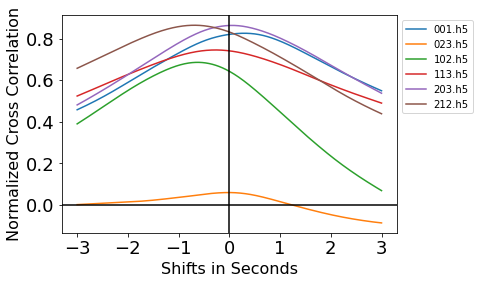

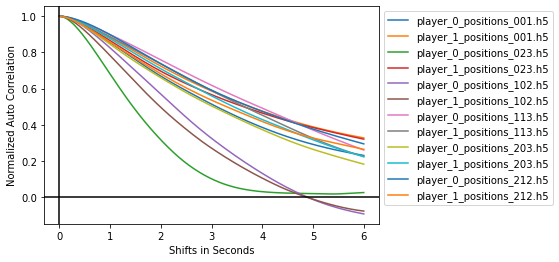

In [11]:
plot_correltations_for_folder(folder='gs_02-09-21_18-56-37',
                              title='')
# shift to left means p0 follows p1

# watched:
# 001 both competition and cooperation, seems like more cooperation in the end
# 023 mostly competition
# 102 played both, a lot of cooperation
# 203 played really cooperative, farmed also grey targets for optimality
# 

# normalized cross correlation got stronger with laps

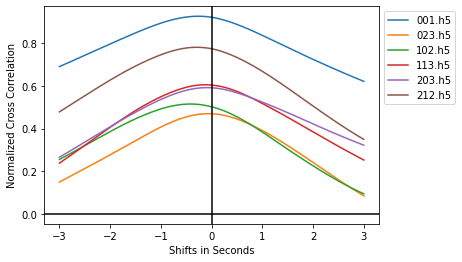

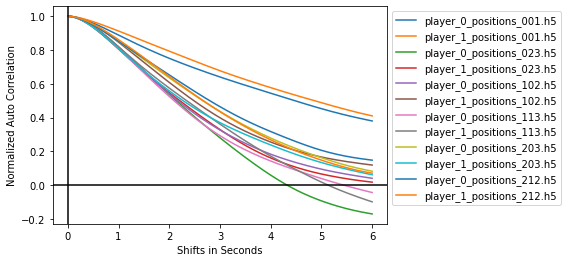

In [42]:
plot_correltations_for_folder(folder='gs_04-09-21_16-26-11',
                              title='')

In [114]:
plot_correltations_for_folder(folder='records_0',
                              title='20 second recordings with direct mouse control')
plot_correltations_for_folder(folder='records_1',
                              title='60 second recordings with constant speed keyboard/wasd control')
plot_correltations_for_folder(folder='records_2',
                              title='60 second recordings with direct mouse control')

In [23]:
def scored(i, score_states):
    return np.isnan(score_states[i-1]) and not np.isnan(score_states[i])

def get_scorings(game_record):
    p0_ss=game_record['player_0_score_state']
    p1_ss=game_record['player_1_score_state']
    p0_ts=game_record['player_0_target_states']
    p1_ts=game_record['player_1_target_states']
    comp_p0, comp_p1, coop_p0, coop_p1 = [], [], [], []
    for i in range(1,len(p0_ss)):
        if scored(i,p0_ss) and scored(i,p1_ss) and int(p0_ts[i]) == int(p1_ts[i]):
            if p0_ss[i] > p1_ss[i]:
                coop_p0.append(i)
            else:
                coop_p1.append(i)
        else:
            if scored(i,p0_ss):
                comp_p0.append(i)
            if scored(i,p1_ss):
                comp_p1.append(i)
    return comp_p0, comp_p1, coop_p0, coop_p1

In [24]:
########################
#         TODO         #
########################

def frame_diffs_between_targets(targets, other_targets):
    targets = sorted(targets)
    other_targets = sorted(other_targets)
    last_target = -1
    frame_diffs = []  # first target has no predecessor
    while targets and other_targets:
        if targets[0] < other_targets[0]:
            if last_target != -1:
                frame_diffs.append(targets[0]-last_target)
            else:
                frame_diffs.append(None)
            last_target = targets.pop(0)
        else:
            last_target = -1
            _ = other_targets.pop(0)
    while targets:
        if last_target != -1:
            frame_diffs.append(targets[0]-last_target)
        else:
            frame_diffs.append(None)
        last_target = targets.pop(0)
    return frame_diffs

def avg_sec_between_targets(targets, other_targets):
    frame_diffs = frame_diffs_between_targets(targets, other_targets)
    frame_diffs = list(filter(None, frame_diffs))
    avg_frame_diffs = sum(frame_diffs)/len(frame_diffs)
    return avg_frame_diffs/conf.pos_updates_ps
        
comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(game_data)


In [25]:
avg_time_between_comp_p0 = avg_sec_between_targets(comp_p0, coop_p0 + coop_p1)
avg_time_between_comp_p1 = avg_sec_between_targets(comp_p1, coop_p0 + coop_p1)
print(avg_time_between_comp_p1)
print(avg_time_between_comp_p0)

#for coop only: (speed=10, occ_time=1)
#p1: 2.3785714285714286
#p0: 2.414236111111111

ZeroDivisionError: division by zero

In [26]:
avg_time_between_coop = avg_sec_between_targets(coop_p0 + coop_p1, comp_p0 + comp_p1)
print(avg_time_between_coop)

2.0403508771929824


In [27]:
def get_player_idx_of_tournament(recordings):
    players = []
    for record in recordings:
        if record['p0_idx'] not in players:
            players.append(record['p0_idx'])
        if record['p1_idx'] not in players:
            players.append(record['p1_idx'])
    return players

def get_player_amount(recordings):
    return 1 + max(get_player_idx_of_tournament(recordings))

def get_lap_amount(recordings):  
    highest_lap = float('-inf')
    for record in recordings:
        if record['lap'] > highest_lap:
            highest_lap = record['lap']
    return highest_lap + 1 # + 1 because lap numeration starts with a 0

def get_lap_frame_amount(recordings):
    return len(recordings[0]['timestamps'])

In [28]:
recordings = None

def get_coop_frac_window(record, window):
    comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(record)
    comp = comp_p0 + comp_p1
    coop = coop_p0 + coop_p1
    frame_amount = len(record['timestamps'])
    coop_frac = [None for _ in range(window)]
    for i in range(window, frame_amount):
        frames = set(range(i - window, i + 1))
        comp_count = len(frames.intersection(comp))
        coop_count = len(frames.intersection(coop))
        if comp_count + coop_count != 0:
            coop_frac.append(coop_count/(coop_count+comp_count))
        else:
            coop_frac.append(None)
    return coop_frac

def plot_coop_fracs(recordings, window):
    fig, axis = plt.subplots(nrows=len(recordings), ncols=1, figsize=((16,4*len(recordings))), sharey='col')
    for i, record in enumerate(recordings):
        coop_frac = get_coop_frac_window(record, window)
        axis[i].plot(frames_to_mins(list(range(len(coop_frac)))), coop_frac)

def get_coop_frac_window_for_player(recordings, window):
    player_amount = get_player_amount(recordings)
    lap_amount = get_lap_amount(recordings)
    player_coop_frac = [[None for _ in range(lap_amount)] for _ in range(player_amount)]
    for record in recordings:
        coop_frac = get_coop_frac_window(record, window)
        lap = record['lap']
        p0 = record['p0_idx']
        p1 = record['p1_idx']
        player_coop_frac[p0][lap] = coop_frac
        player_coop_frac[p1][lap] = coop_frac
    return [sum(p_coop_frac, []) for p_coop_frac in player_coop_frac]

def get_tournament_frame_amount(recordings):
    return get_lap_amount(recordings) * get_lap_frame_amount(recordings)
    

def plot_coop_fracs_for_player(recordings, window):
    player_amount = get_player_amount(recordings)
    frames = list(range(get_tournament_frame_amount(recordings)))
    fig, axis = plt.subplots(nrows=player_amount, ncols=1, figsize=((16,4*player_amount)), sharey='col')
    coop_fracs = get_coop_frac_window_for_player(recordings, window)
    lines = []
    for p in range(player_amount):
        lines.append(axis[p].plot(frames_to_mins(frames), coop_fracs[p])[0])
    return lines

from matplotlib.widgets import Slider
        
def interactive_ma_coop_frac_for_player(recordings, windows=[10, 30, 60]):
    %matplotlib tk
    frames = list(range(get_tournament_frame_amount(recordings)))
    coop_fracs_for_win = [get_coop_frac_window_for_player(recordings, w) for w in windows]
    player_amount = get_player_amount(recordings)
    fig, axis = plt.subplots(nrows=player_amount, ncols=1, figsize=((16,4*player_amount)), sharey='col')
    ma_slider = Slider(
        ax=plt.axes([0.25, 0.1, 0.65, 0.03]),
        label='Moving average window in seconds',
        valmin=10,
        valmax=60,
        valstep=np.array(windows),
        valinit=30)
    for p in range(player_amount):
        axis[p].plot(frames_to_mins(frames), coop_fracs_for_win[2][p])
    def update(val):
        print(val)
        #l.set_ydata(amp*np.sin(2*np.pi*freq*t))
        for p in range(player_amount):
            axis[p].plot(frames_to_mins(frames), coop_fracs_for_win[val][p])
        fig.canvas.draw_idle()
    ma_slider.on_changed(update)
    plt.show()

In [29]:
windows = [3+2*i for i in range(6)] + [15+5*i for i in range(11)]

In [30]:
def add_coop_fracs_windows(recordings, windows):
    for record in recordings:
        record['coop_fracs_windows'] = []
        for w in windows:
            #print(get_coop_frac_window(record, w))
            record['coop_fracs_windows'].append(get_coop_frac_window(record, w * conf.pos_updates_ps))
            

In [12]:
print(len(retreat_record[0]['coop_fracs_windows']))
print(len(windows))

NameError: name 'retreat_record' is not defined

In [31]:
# TODO !!!!!!!!!!!!!!!
# TODO: x axis changes with window

import matplotlib.ticker as mtick
            
def show_coop_fracs(recordings, windows):
    colors = ['#a6cee3','#df8a8a', '#1f78b4','#a02c2c']
    %matplotlib tk
    init_start_win_inx = 9
    
    #player_amount = get_player_amount(recordings)
    #lap_frame_amount = get_lap_frame_amount(recordings)
    frame_mins = frames_to_mins(list(range(get_lap_frame_amount(recordings))))

    #fig, axis = plt.subplots(nrows=player_amount, ncols=1, figsize=((16,4*player_amount)), sharey='col')
    fig, axis = plt.subplots(nrows=2, ncols=3, figsize=((16,8)), sharey='all')
    fig.suptitle(f'Moving average ({windows[init_start_win_inx]} seconds) over score per second', fontsize=24)
    #plt.subplots_adjust(bottom=0.20, hspace=0.33)
    plt.subplots_adjust(bottom=0.33)
    
    def adapt_axis(window_idx):
        fig.suptitle(f'Moving average ({windows[window_idx]} seconds) over fraction of cooperations', fontsize=24)
        for row in axis:
            for ax in row:
                ax.clear()
                ax.tick_params(axis='both', which='major', labelsize=22) 
        for ax in axis[0]:
            ax.tick_params(axis='x', which='both', labelbottom=False)
        for ax in axis[1]:
            ax.set_xlabel('Minute of recording', fontsize=20)
        for ax in axis[:,0]:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
        for col in axis[:,1:]:
            for ax in col:
                ax.tick_params(axis='y', which='both', labelleft=False)
                
        
        #for player_idx in range(player_amount):
        #    axis[player_idx].clear()
            #axis[player_idx].set_ylabel(f'player {player_idx+1}', fontsize=16)
        #    axis[player_idx].set_ylabel(f'score/sec', fontsize=20)
        #    axis[player_idx].set_title(f'Player {player_idx + 1} vs {oppenents[player_idx]}', fontsize=20)
            
        #axis[0].set_title(f'Moving average ({windows[init_start_win_inx]} seconds) over score per second', fontsize=20)
        #for i in [0,1,2]:
        #    axis[i].tick_params(
        #        axis='x',          # changes apply to the x-axis
        #        which='both',      # both major and minor ticks are affected
        #        bottom=True,      # ticks along the bottom edge are off
        #        top=True,         # ticks along the top edge are off
        #        labelbottom=False) # labels along the bottom edge are off 
        #for ax in axis:
        #    ax.tick_params(axis='both', which='major', labelsize=22) 
    
    def plot_scores(window_idx):
        adapt_axis(window_idx)
        for i, record in enumerate(recordings):
            row = 0 if record['p0_idx'] == 0 or record['p1_idx'] == 0 else 1
            lap = record['lap']
            p0_num = record['p0_idx'] + 1
            p1_num = record['p1_idx'] + 1
            axis[row, lap].set_title(label=f'Player {p0_num} vs {p1_num}',
                                     fontsize=20)
            axis[row, lap].plot(frame_mins,
                                record['coop_fracs_windows'][window_idx],
                                linewidth=2)
                                #color=colors[1], TODO
                                #label='cooperative score opponent')
            
            
        #for player_idx in range(player_amount):
        #    axis[player_idx].plot(frame_mins,
        #                          score_dicts_for_win[window_idx][player_idx]['coop_opp'],
        #                          linewidth=2,
        #                          color=colors[1],
        #                          label='cooperative score opponent')
        #    axis[player_idx].plot(frame_mins,
        #                          score_dicts_for_win[window_idx][player_idx]['coop'],
        #                          linewidth=2,
        #                          color=colors[0],
        #                          label='cooperative score')
        #    axis[player_idx].plot(frame_mins,
        #                          score_dicts_for_win[window_idx][player_idx]['comp_opp'],
        #                          linewidth=2,
        #                          color=colors[3],
        #                          label='competitive score opponent')
        #    axis[player_idx].plot(frame_mins,
        #                          score_dicts_for_win[window_idx][player_idx]['comp'],
        #                          linewidth=2,
        #                          color=colors[2],
        #                          label='competitive score')
        #axis[-1].legend(bbox_to_anchor=(1,-1.3), loc='lower right', fontsize=14)
    
    plot_scores(window_idx=init_start_win_inx)

    ma_slider = Slider(
        ax=plt.axes([0.40, 0.1, 0.2, 0.03]),
        label='MA window in secs',
        valmin=windows[0],
        valmax=windows[-1],
        valstep=np.array(windows),
        valinit=windows[init_start_win_inx])

    def update(val):
        w = windows.index(val)
        
        plot_scores(w)
                
        fig.canvas.draw_idle()
        #axis[0].set_title(f'Moving average ({val} seconds) over score per second', fontsize=20)

    ma_slider.on_changed(update)
    plt.show()
    return ma_slider

In [32]:
add_coop_fracs_windows(retreat_record, windows)

In [33]:
_ = show_coop_fracs(retreat_record, windows)

In [34]:
add_coop_fracs_windows(wg_record, windows)

In [35]:
_ = show_coop_fracs(wg_record, windows)

In [24]:
def get_scores_for_frame(record, frame):
    p0_ss=record['player_0_score_state']
    p1_ss=record['player_1_score_state']
    scores = [0, 0]
    if not np.isnan(p0_ss[frame]) and np.isnan(p0_ss[frame-1]):
        scores[0] = int(p0_ss[frame])
    if not np.isnan(p1_ss[frame]) and np.isnan(p1_ss[frame-1]):
        scores[1] = int(p1_ss[frame])
    return tuple(scores)
   
p0_ss=game_data['player_0_score_state']
get_scores_for_frame(game_data, 2344)

(0, 0)

In [25]:
def gen_player_score_dict_2(window):
    return {'comp'     : [0 for _ in range(window)],
            'coop'     : [0 for _ in range(window)],
            'comp_opp' : [],
            'coop_opp' : []}


def get_scores_window_2(record, window):
    frame_amount = len(record['timestamps'])
    secs_win = window / conf.pos_updates_ps
    comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(record)
    coop_score_p0, coop_score_p1  = [], []
    comp_score_p0, comp_score_p1  = [], []
    p0_win_scores = gen_player_score_dict_2(window)
    p1_win_scores = gen_player_score_dict_2(window)
    for i in range(window, frame_amount):
        win_frames = set(range(i - window, i + 1))
        cs_p0, _ = get_scores_for_frames(record, win_frames, comp_p0)
        _, cs_p1 = get_scores_for_frames(record, win_frames, comp_p1)
        coop_high_p0, coop_low_p1 = get_scores_for_frames(record, win_frames, coop_p0)
        coop_low_p0, coop_high_p1 = get_scores_for_frames(record, win_frames, coop_p1)
        p0_win_scores['comp'].append(cs_p0 / secs_win)
        p1_win_scores['comp'].append(cs_p1 / secs_win)
        p0_win_scores['coop'].append((coop_low_p0 + coop_high_p0) / secs_win)
        p1_win_scores['coop'].append((coop_low_p1 + coop_high_p1) / secs_win)
    p0_win_scores['comp_opp'] = p1_win_scores['comp']
    p0_win_scores['coop_opp'] = p1_win_scores['coop']
    p1_win_scores['comp_opp'] = p0_win_scores['comp']
    p1_win_scores['coop_opp'] = p0_win_scores['coop']
    return p0_win_scores, p1_win_scores

def get_scores_for_frames(record, frames, scored_frames):
    p0_scores, p1_scores = 0, 0
    for frame in frames.intersection(scored_frames):
        p0_s, p1_s = get_scores_for_frame(record, frame)
        p0_scores += p0_s
        p1_scores += p1_s
    return p0_scores, p1_scores

def get_scores_windowed_for_player_2(recordings, window):
    player_amount = get_player_amount(recordings)
    lap_amount = get_lap_amount(recordings)
    scores_player_lap = [[None for _ in range(lap_amount)] for _ in range(player_amount)]
    for record in recordings:
        p0_scores, p1_scores = get_scores_window_2(record, window)
        lap = record['lap']
        p0 = record['p0_idx']
        p1 = record['p1_idx']
        scores_player_lap[p0][lap] = p0_scores  # todo who plays against who?
        scores_player_lap[p1][lap] = p1_scores
        
    player_score_dicts = [gen_player_score_dict_2(0) for _ in range(player_amount)]
    for p in range(player_amount):
        for lap_scorings in scores_player_lap[p]:
            player_score_dicts[p]['comp'].extend(lap_scorings['comp'])
            player_score_dicts[p]['coop'].extend(lap_scorings['coop'])
            player_score_dicts[p]['comp_opp'].extend(lap_scorings['comp_opp'])
            player_score_dicts[p]['coop_opp'].extend(lap_scorings['coop_opp'])
    return player_score_dicts

In [26]:
def gen_layer_score_dict_stacked():
    return {'coop_self'  : [],
            'coop_total' : [],
            'coop_total_plus_comp_self'  : [],
            'total'                      : []}

def scores_windows_for_player_2_stacked(recordings, window):
    player_score_dicts = get_scores_windowed_for_player_2(recordings, window)
    player_score_dicts_stacked = [gen_layer_score_dict_stacked() for _ in range(len(player_score_dicts))]
    for i, p_dict in enumerate(player_score_dicts):
        player_score_dicts_stacked[i]['coop_self'] = p_dict['coop']
        player_score_dicts_stacked[i]['coop_total'] = [a + b for a, b in zip(p_dict['coop_opp'], player_score_dicts_stacked[i]['coop_self'])]
        player_score_dicts_stacked[i]['coop_total_plus_comp_self'] = [a + b for a, b in zip(p_dict['comp'], player_score_dicts_stacked[i]['coop_total'])]
        player_score_dicts_stacked[i]['total'] = [a + b for a, b in zip(p_dict['comp_opp'], player_score_dicts_stacked[i]['coop_total_plus_comp_self'])]
    return player_score_dicts_stacked     
    
        

In [27]:
####################
#      TODO        #
####################
# - remove redundant plots

def show_ma_scores_3(recordings, score_dicts_for_win, windows):
    #colors = ['#b2df8a','#33a02c', '#a6cee3','#1f78b4']
    #colors = ['#b2df8a','#a6cee3', '#33a02c','#1f78b4']
    #colors = ['#a6cee3','#b2df8a', '#1f78b4','#33a02c']
    colors = ['#a6cee3','#df8a8a', '#1f78b4','#a02c2c']
    oppenents = ['2, 3, 4',
                 '1, 4, 3',
                 '4, 1, 2',
                 '3, 2, 1']
    #colors = ['#1f78b4','#a6cee3', '#33a02c','#b2df8a']
    %matplotlib tk
    init_start_win_inx = 9
    
    player_amount = get_player_amount(recordings)
    lap_frame_amount = get_lap_frame_amount(recordings)
    frame_mins = frames_to_mins(list(range(get_tournament_frame_amount(recordings))))

    fig, axis = plt.subplots(nrows=player_amount, ncols=1, figsize=((16,4*player_amount)), sharey='col')
    plt.subplots_adjust(bottom=0.20, hspace=0.33)
    
    def adapt_axis():
        for player_idx in range(player_amount):
            axis[player_idx].clear()
            #axis[player_idx].set_ylabel(f'player {player_idx+1}', fontsize=16)
            axis[player_idx].set_ylabel(f'score/sec', fontsize=20)
            axis[player_idx].set_title(f'Player {player_idx + 1} vs {oppenents[player_idx]}', fontsize=20)
            
        #axis[0].set_title(f'Moving average ({windows[init_start_win_inx]} seconds) over score per second', fontsize=20)
        axis[-1].set_xlabel('Minute of recording', fontsize=20)
        for i in [0,1,2]:
            axis[i].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=True,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off 
        for ax in axis:
            ax.tick_params(axis='both', which='major', labelsize=22) 
    
    def plot_scores(window_idx):
        adapt_axis()
        for player_idx in range(player_amount):
            axis[player_idx].plot(frame_mins,
                                  score_dicts_for_win[window_idx][player_idx]['coop_opp'],
                                  linewidth=2,
                                  color=colors[1],
                                  label='cooperative score opponent')
            axis[player_idx].plot(frame_mins,
                                  score_dicts_for_win[window_idx][player_idx]['coop'],
                                  linewidth=2,
                                  color=colors[0],
                                  label='cooperative score')
            axis[player_idx].plot(frame_mins,
                                  score_dicts_for_win[window_idx][player_idx]['comp_opp'],
                                  linewidth=2,
                                  color=colors[3],
                                  label='competitive score opponent')
            axis[player_idx].plot(frame_mins,
                                  score_dicts_for_win[window_idx][player_idx]['comp'],
                                  linewidth=2,
                                  color=colors[2],
                                  label='competitive score')
        axis[-1].legend(bbox_to_anchor=(1,-1.3), loc='lower right', fontsize=14)
        fig.suptitle(f'Moving average ({windows[window_idx]} seconds) over score per second', fontsize=24)
    
    plot_scores(window_idx=init_start_win_inx)

    ma_slider = Slider(
        ax=plt.axes([0.40, 0.1, 0.2, 0.03]),
        label='MA window in secs',
        valmin=windows[0],
        valmax=windows[-1],
        valstep=np.array(windows),
        valinit=windows[init_start_win_inx])

    def update(val):
        w = windows.index(val)
        
        plot_scores(w)
                
        fig.canvas.draw_idle()
        #axis[0].set_title(f'Moving average ({val} seconds) over score per second', fontsize=20)

    ma_slider.on_changed(update)
    plt.show()
    return ma_slider

In [28]:
scores_for_win_retreat_dict_3 = [get_scores_windowed_for_player_2(retreat_record, w * conf.pos_updates_ps) for w in windows]

In [31]:
_ = show_ma_scores_3(retreat_record, scores_for_win_retreat_dict_3, windows)

In [25]:
scores_for_win_wg_dict_3 = [get_scores_windowed_for_player_2(wg_record, w * conf.pos_updates_ps) for w in windows]

In [26]:
_ = show_ma_scores_3(retreat_record, scores_for_win_wg_dict_3, windows)